In [11]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse
from matplotlib.patches import Rectangle



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# this script generates a tm as per Schiffels' equations - i.e. these are the theoretical transition probabilities

# it needs: an N_0, N_T and a lambda array which corresponds to population size per time interval

import math
import numpy as np
import pdb

def abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def corrected_abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
                pre = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) 
#                 print('with L(alpha)^2 = {} and H_i(alpha) = {} and H_alpha(alpha)= {}'.format(L(T[alpha+1],T[alpha])**2,(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T))),(1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha)))))
                B = (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
                pre = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = q_2_sum2(beta)
                B = (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))

        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_



In [3]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

# this heatmap works well for values between -1 and 1
def heatmaps_div_patch(matrix,title='',patch=[1,1]):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax.add_patch(Rectangle((0, patch[0]), len(matrix), patch[1], fill=False, edgecolor='black', lw=2))
#     ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

In [4]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}\n\n')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04090434 0.04548135 0.0505705  0.05622911
 0.06252089 0.06951668 0.07729528 0.08594426 0.09556103 0.10625386
 0.11814318 0.13136285 0.14606175 0.16240538 0.18057779 0.20078361
 0.22325037 0.24823105 0.27600695 0.30689085 0.34123052 0.37941263
 0.42186715 0.46907213 0.52155912 0.57991917 0.64480944 0.71696063
 0.79718521 0.88638654 0.98556909 1.0958497  1.21847021 1.35481138
 1.5064085  1.67496864 1.86238987 2.07078267 2.30249366 2.56013204
 2.84659895 3.16512019 3.51928248 3.91307389 4.35092873 4.83777751
 5.3791024  5.98099905 6.65024514]


T_scaled_np is [     0.            735.75888234    818.08689348    909.62702774
   1011.41007904   1124.58218235   1250.41771984   1390.33367116
   1545.90556937   1718.88524244   1911.22053974   2125.07726597
   2362.86356935   2627.25705872   2921.23495497   3248.1076162
   3611.55581425   4015.67218228   4465.00730015   4964.62093654
   5520.13902479   6137.81701413   6824.61030959   7588.2525938
   8437.34291267

In [5]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [6]:
def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def psc_pop(seq_length,T_1 = 15000,T_2=26500):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_A*2,growth_rate=0),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_A,growth_rate=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=50,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

## Comparison for panmictic population of constant size

Compare observations against theoretical

In [8]:
sim1 = const_pop(150e+06)
# flagsim

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



In [9]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

Now collect observed data about transitioning between each state and plot this in a matrix

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


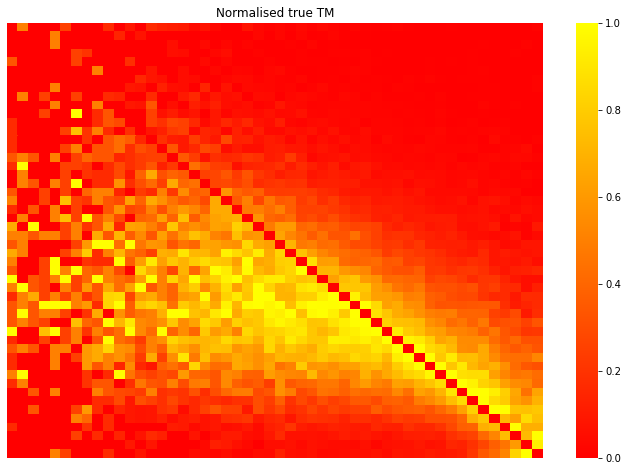

In [12]:
tmrca_data1 = get_coal_data(sim1, args) # get true coalescent 
coal_times_absolute1 = round_bin_coal_data(sim1.sequence_length,tmrca_data1, args) # partition coalescent data into bins  
coal_times1 = coal_times_absolute1/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals1 = round_coal_times(coal_times1,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm1 = tm_counts(coal_times_intervals1,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd1 = np.copy(tm1)
tm_nd1[range(0,len(tm1)),range(0,len(tm1))] = 0
tm_nd_norm1 = normalise(tm_nd1,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd1,'colmax'),title='Normalised true TM') # show heatmap


Now create this matrix by theory and see what we get. 
Start with the old theory (i.e. that given by Schiffels in the supplementary note)

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


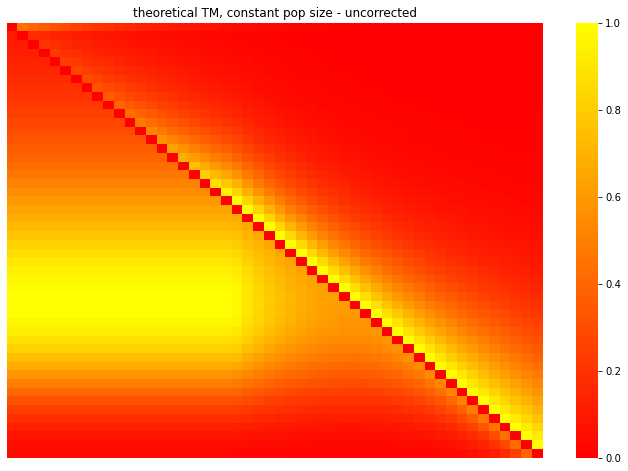

In [13]:
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2A, q_2_upperA, q_2_lowerA, q_1A, q_A = abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2A,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

The shape is reasonable, but there is lacking intensity in the middle of the plot, below the diagonal. I believe this is because there is a mistake in Schiffels' equation 26, see my notepad page 12 and 13. Below I implement what i believe to be the correction

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


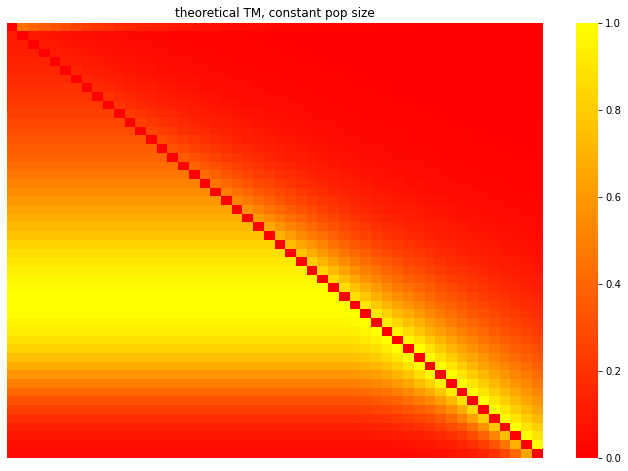

In [14]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Ac,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperAc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

Now we see that, I think, this fits the data well.

Now I look at the difference in probabilites between the observed data and the theoretical data. Start with the old theory (before the correction) 

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


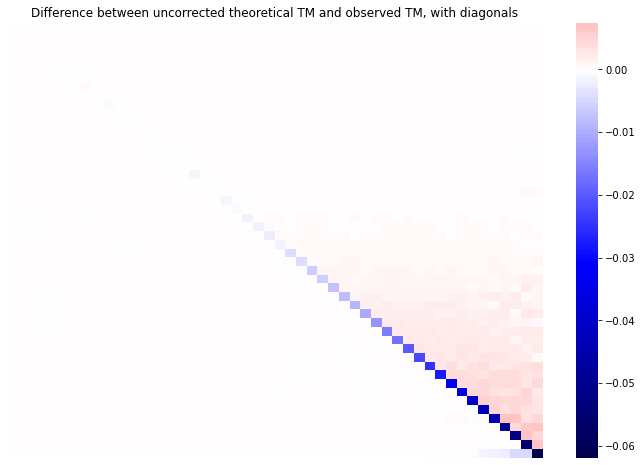

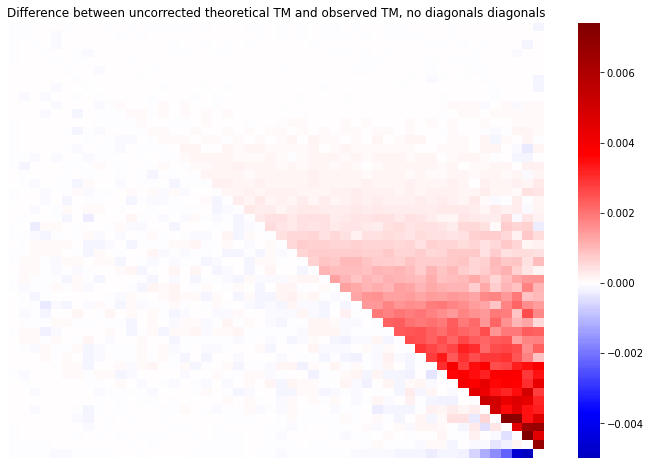

In [15]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_1 = normalise(tm1,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_tmA = q_A - tm_1
diff_q_tm_ndA = np.copy(diff_q_tmA)
diff_q_tm_ndA = remove_diagonals(diff_q_tm_ndA)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmA,title="Difference between uncorrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndA,title="Difference between uncorrected theoretical TM and observed TM, no diagonals diagonals")


Notice that there is significant and systematic deviance from the theory to the observation in the upper diagonal. This confirms that I think there has been a mistake. 

Now I look at the difference in probabilites between the observed data and the corrected theoretical data.

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


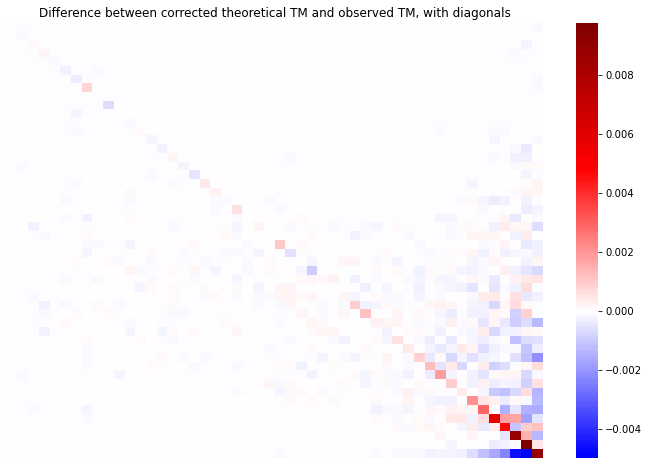

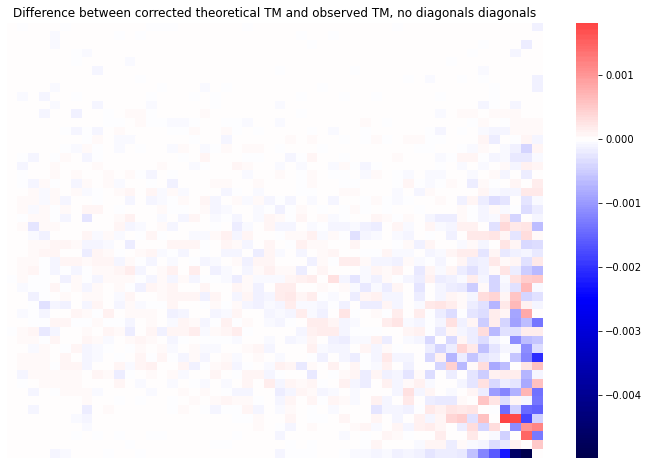

In [16]:

diff_q_tmAc = q_Ac - tm_1
diff_q_tm_ndAc = np.copy(diff_q_tmAc)
diff_q_tm_ndAc = remove_diagonals(diff_q_tm_ndAc)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmAc,title="Difference between corrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndAc,title="Difference between corrected theoretical TM and observed TM, no diagonals diagonals")


Notice that there is a good fit; yes, there is noise, but it looks quite good.

Now compare correction theory vs uncorrected theory

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


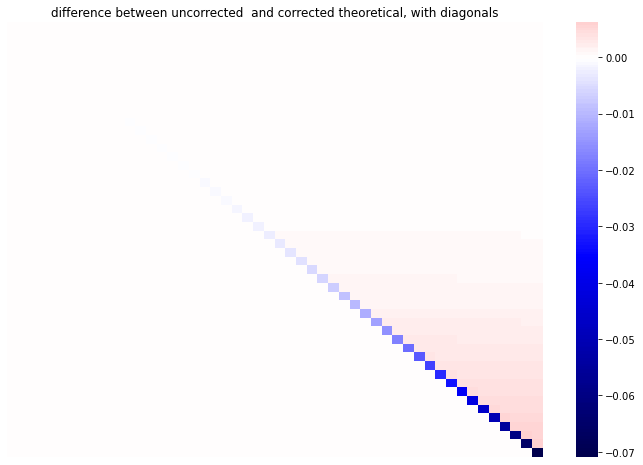

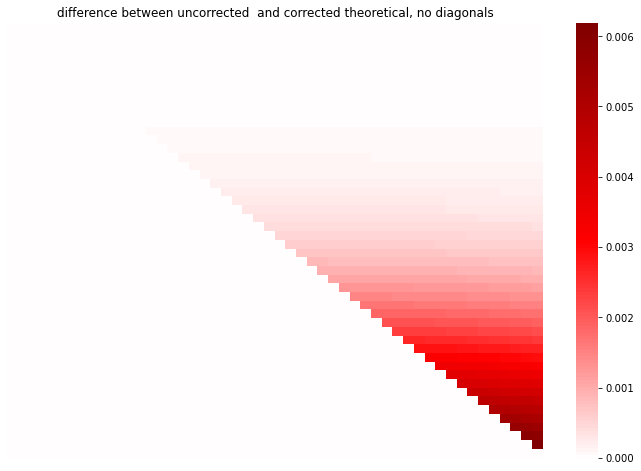

In [17]:

diff_q_A_q_Ac = q_A - q_Ac
diff_q_A_q_Ac_nd = np.copy(diff_q_A_q_Ac)
diff_q_A_q_Ac_nd = remove_diagonals(diff_q_A_q_Ac_nd)

heatmaps_div(diff_q_A_q_Ac,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_A_q_Ac_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

Note the small diferences in each

## Comparison for panmictic population of changing size

Compare observations against theoretical for a population that is panmictic but has changing population size. 

In [19]:
sim2 = psc_pop(150e+06)


Model =  hudson(reference_size=1)
Epoch: 0 -- 15000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 15000.0
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 15000.0 -- 26500.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 26500.0
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 26500.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


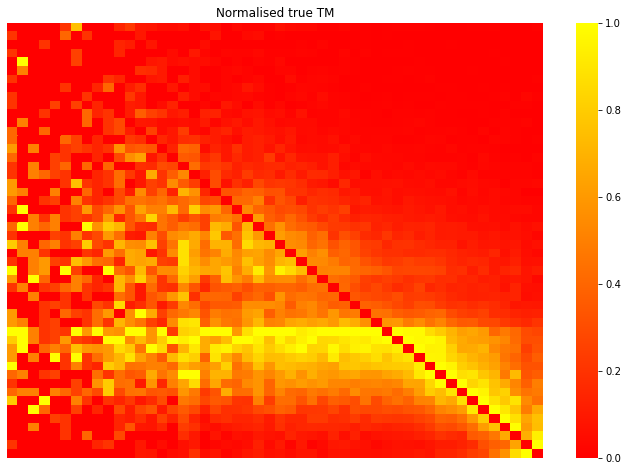

In [20]:
tmrca_data2 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


#### Time changes that don't align with the predefined time intervals

We have above T_1 = 15000 and T_2 = 26500. We have from our predefind time intervals (scaling by coalescent time) that T_np*2*N_0[29:36] = [14339.2, 15943.7, 17727.7, 19711.3,21917.0, 24369.4, 27096.2]. I will investigate the effects of how we set these boundaries.

#### Scenario A: pop_size[29:35] = 2

In [95]:
[T_np*2*N_0][0][29:36]

array([14339.21266816, 15943.70415104, 17727.73079936, 19711.38176658,
       21916.99408938, 24369.40421542, 27096.22767576])

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


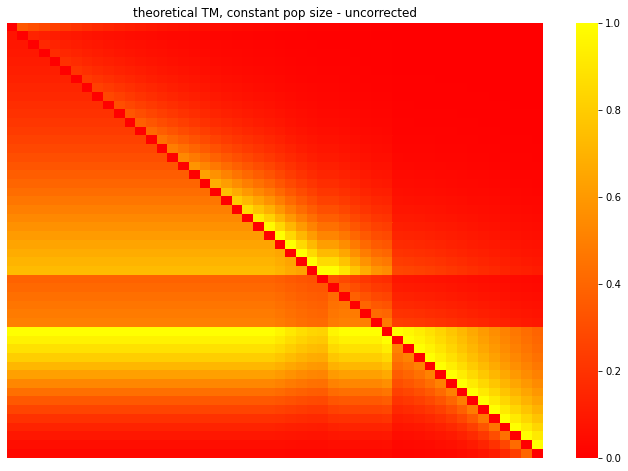

In [21]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[29:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2B, q_2_upperB, q_2_lowerB, q_1B, q_B = abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2B,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerB,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerB,'colmax')+normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think I spotted a mistake in equation 26 ( missing factor of (1/(2*lambda_alpha)), see my notedpad page 12 and 13), so I have tried to correct it

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


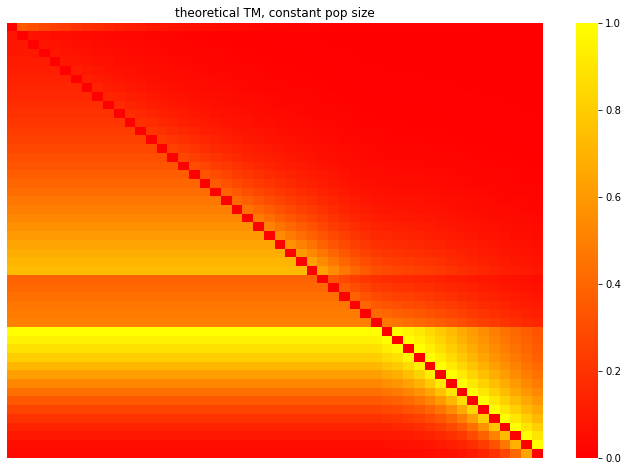

In [22]:
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

Note that after my correction the fit of the theory (eyeballing) to the data looks better

Comparison between (un)corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


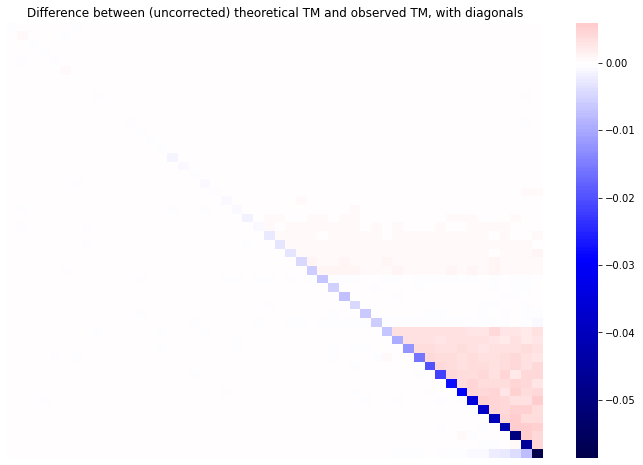

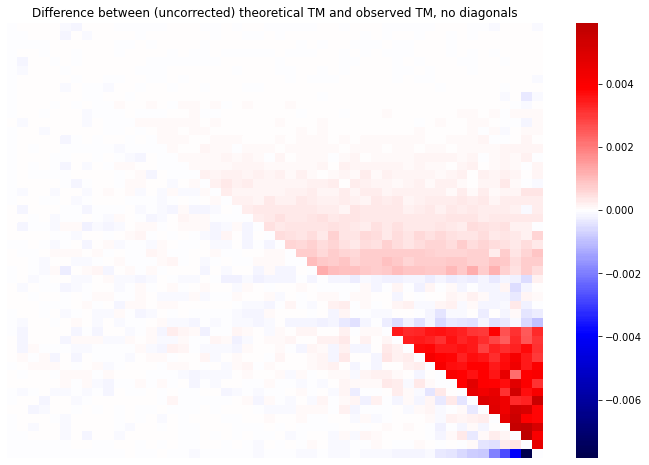

In [23]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_B_tm2 = q_B - tm_2
diff_q_B_tm_nd2 = np.copy(diff_q_B_tm2)
diff_q_B_tm_nd2 = remove_diagonals(diff_q_B_tm_nd2)

# heatmaps_seq(q_2B,title=" (uncorrected) theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_B_tm2,title="Difference between (uncorrected) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_B_tm_nd2,title="Difference between (uncorrected) theoretical TM and observed TM, no diagonals")


Comparison between corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


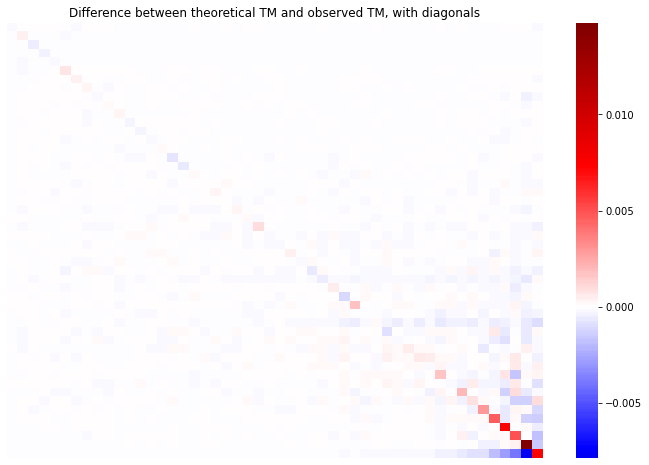

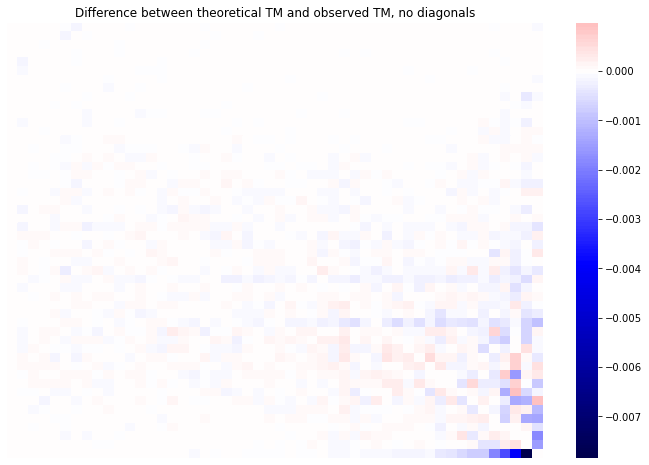

In [24]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Note that there is a good fite between the theory and the data, when I implement the correction. 
Difference between uncorrected and corrected theoretical  TM

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


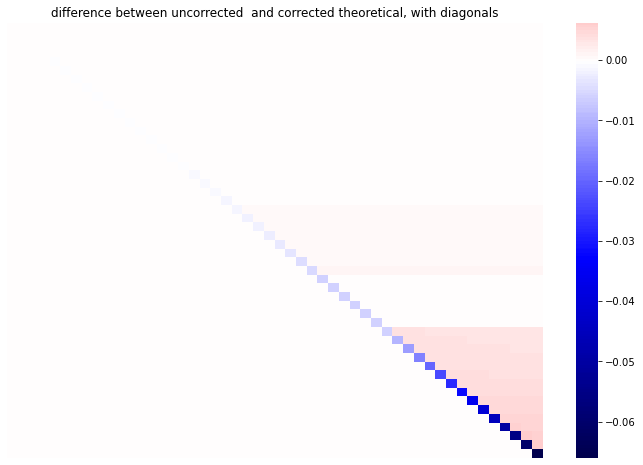

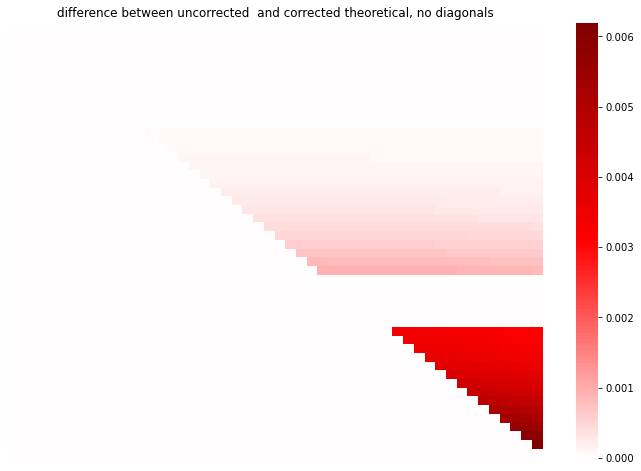

In [25]:

diff_q_B_q_Bc = q_B - q_Bc
diff_q_B_q_Bc_nd = np.copy(diff_q_B_q_Bc)
diff_q_B_q_Bc_nd = remove_diagonals(diff_q_B_q_Bc_nd)

heatmaps_div(diff_q_B_q_Bc,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_B_q_Bc_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

How do two theoretical matrices vary for different histories? I look because I want to gauge variability in randomness and accuracy, as when comparing theory to data

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


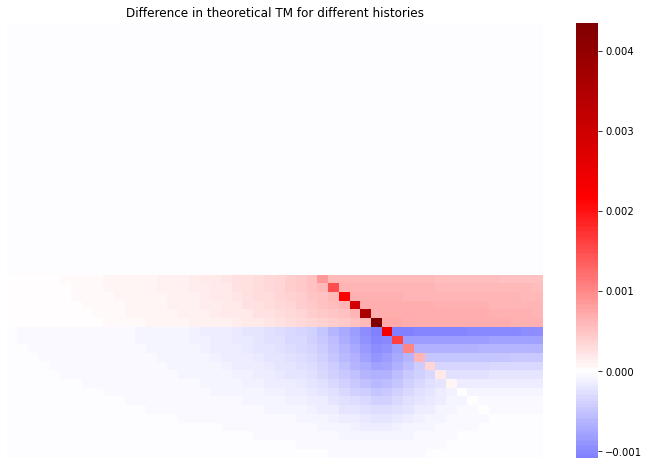

In [26]:
diff_qAc_qBc = q_Ac - q_Bc
heatmaps_div(diff_qAc_qBc,title="Difference in theoretical TM for different histories")

Ok cool, seems like a discernible difference

#### Scenario B: pop_size[29:36] = 2

I will now investiage a different scenario, where the pop size array is defined as above. 

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 20000.
 20000. 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


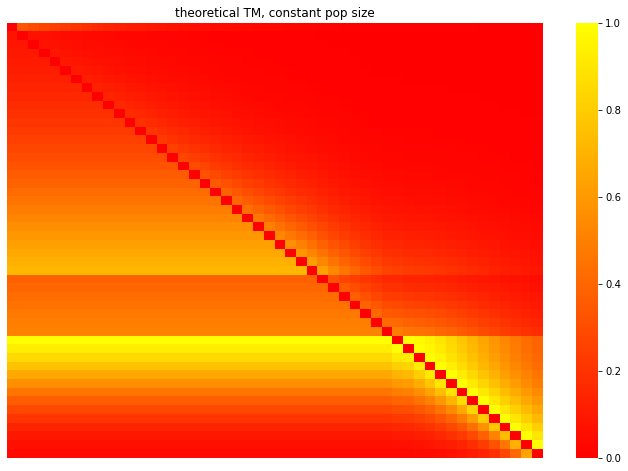

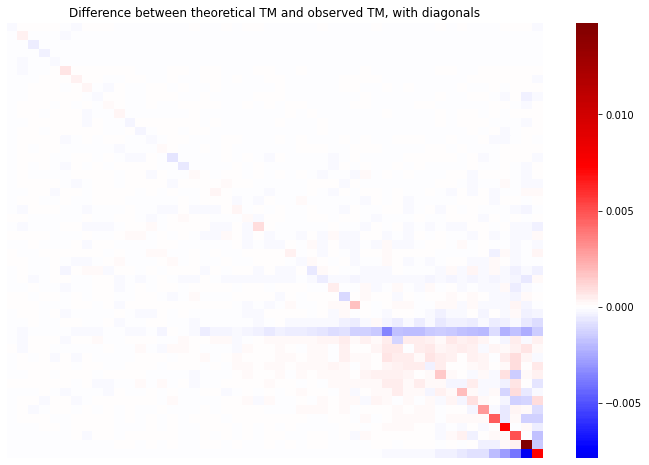

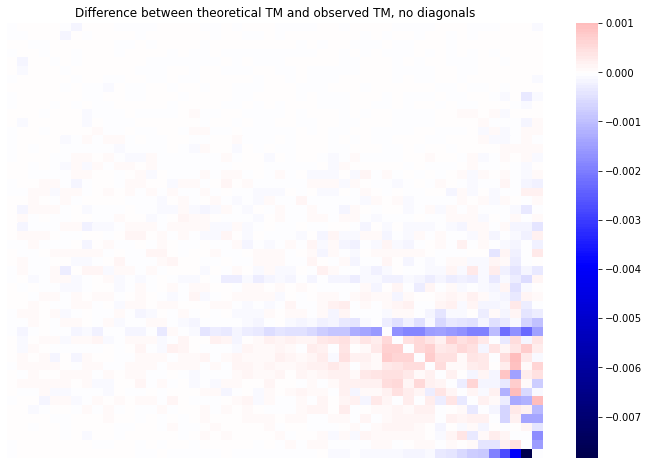

In [27]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[29:36] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


#### Scenario C: pop_size[30:35] = 2

I will now investiage a different scenario, where the pop size array is defined as above. 

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


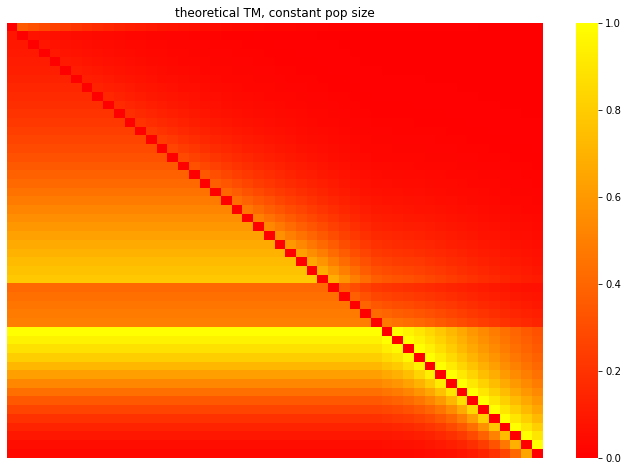

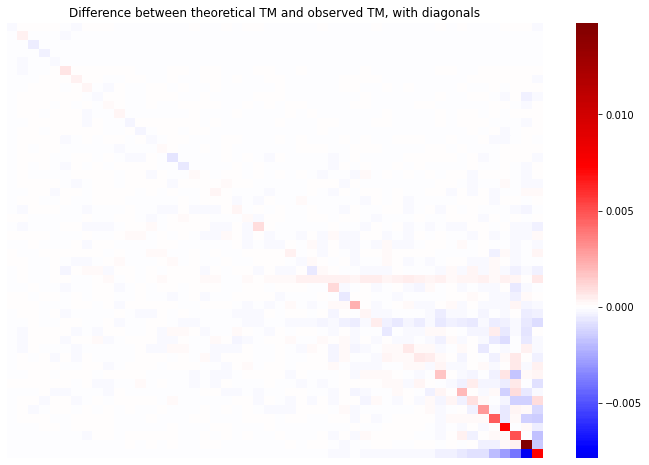

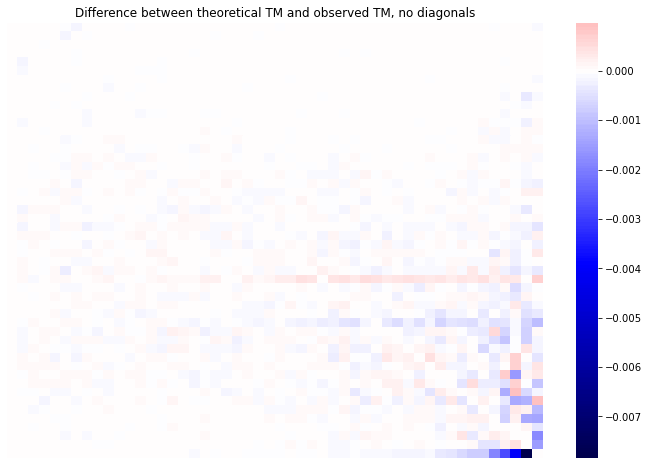

In [28]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[30:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Analysis from scenario A, B and C show that how you define the time intervals is important. The conclusion that I draw is that, given some demographic change at time T_i,  you should take, always, the next lowest time interval when programming in that change. 

For example, suppose there is a population size change at T_1 = 40000, and suppose that you have time intervals T_int[i] = 37844 and T_int[i+1] = 41129. Then, you should, I think, always take the lower T_int[i]. 

#### Time changes that DO align with the predefined time intervals

This should mean there won't be any "streaks" , because the corresponding times of changing size match the time intervals

In [16]:
T_1 = T_np[30]*2*N_0
T_2 = T_np[35]*2*N_0
print('T_1 and T_2 are {}'.format([T_1,T_2]))
sim2a = sim2 = psc_pop(150e+06,T_1=T_1,T_2=T_2)


T_1 and T_2 are [15943.704151042171, 27096.22767576434]
Model =  hudson(reference_size=1)
Epoch: 0 -- 15943.704151042171 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 15943.704151042171
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 15943.704151042171 -- 27096.22767576434 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 27096.22767576434
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 27096.22767576434 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


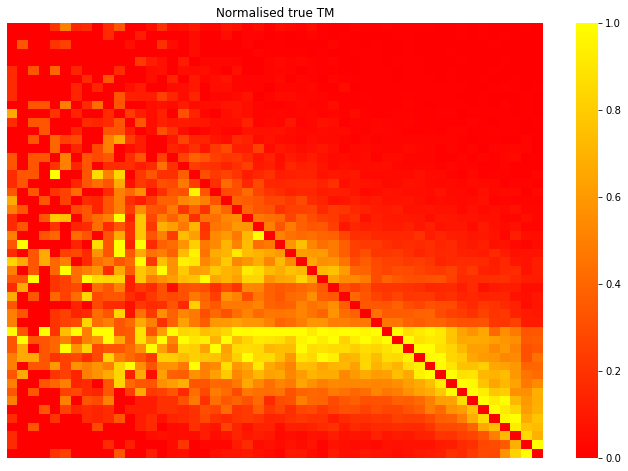

In [19]:
tmrca_data2 = get_coal_data(sim2a, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 20000. 20000. 20000. 20000. 20000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


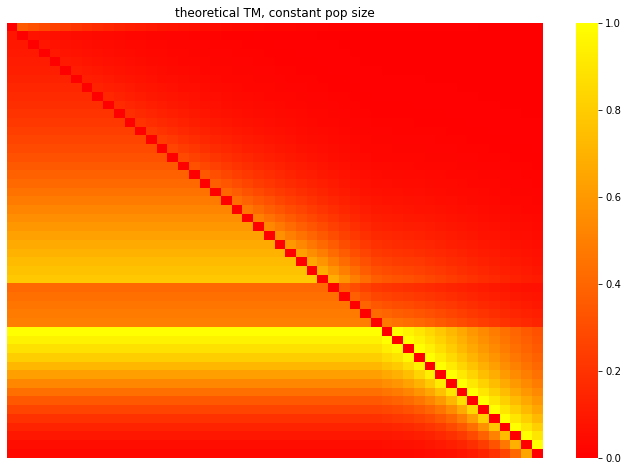

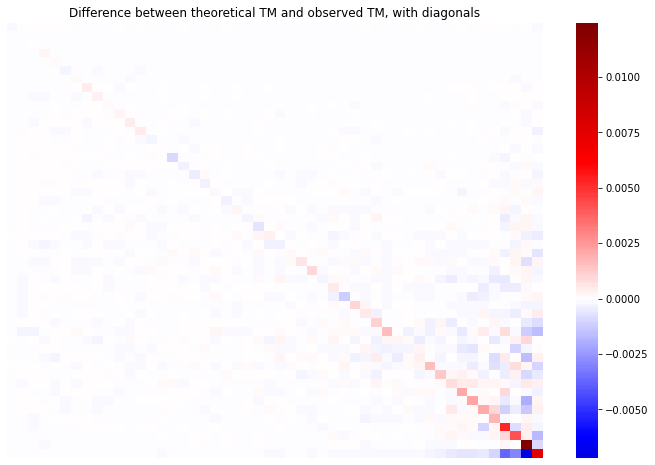

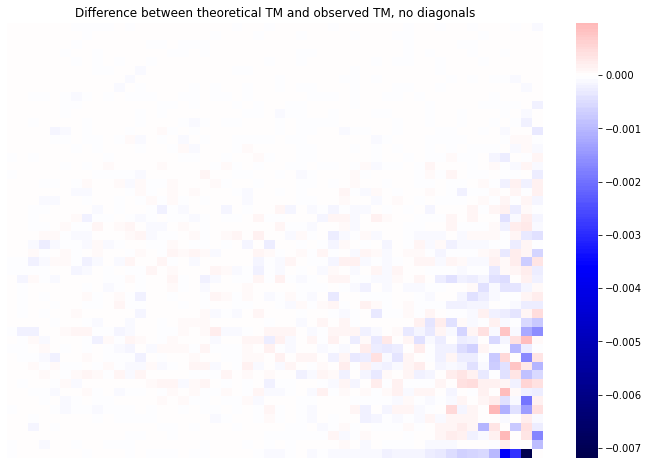

In [31]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[30:35] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04

q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


No streaks when the times of change align with time intervals. I am satisfied with this. 

## Investigating the bad diagonals stuff

SOLVED: I think this is because the recombination rate was defined per bp per gen, which i specified as r=2e-08. The problem is that when I count observations of transitions in a genome sequence, I was counting by bins in some size (say bin_length=50). Therefore obviously the theory woulnd't be correct due to mismatch in rate of recombination. The solution is to multipy the recombination rate by the length of your bins, i.e. set r=2e-08*bin_length. Below are some examples demonstrating. 


##### The defaultl bin size used in the above analysis was: 50, I will fiddle with this now and see how things differ

Now I will change that and see how results differ

In [84]:
args.bin_length = 50

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


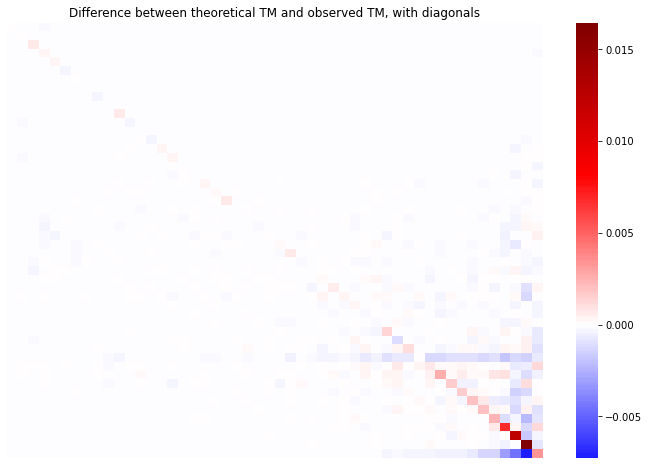

In [85]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [86]:
args.bin_length=20

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


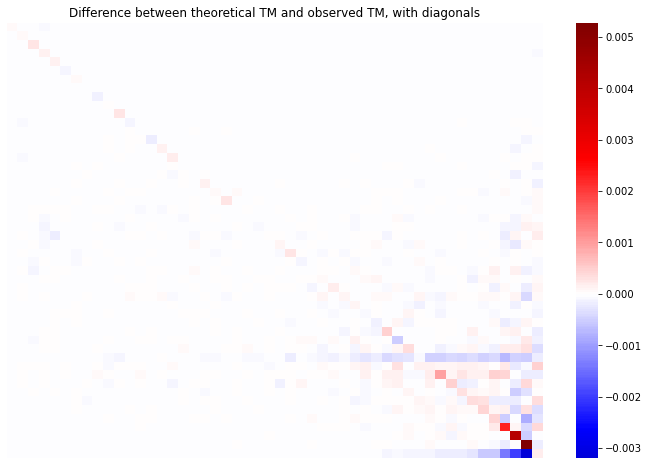

In [89]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [92]:
args.bin_length = 10

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


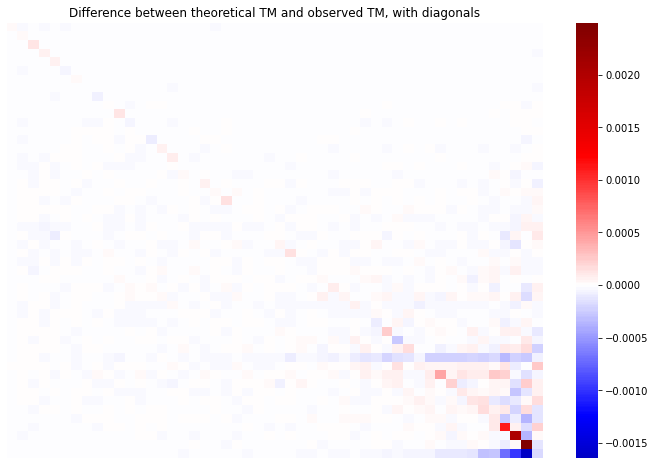

In [93]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [94]:
args.bin_length = 2

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


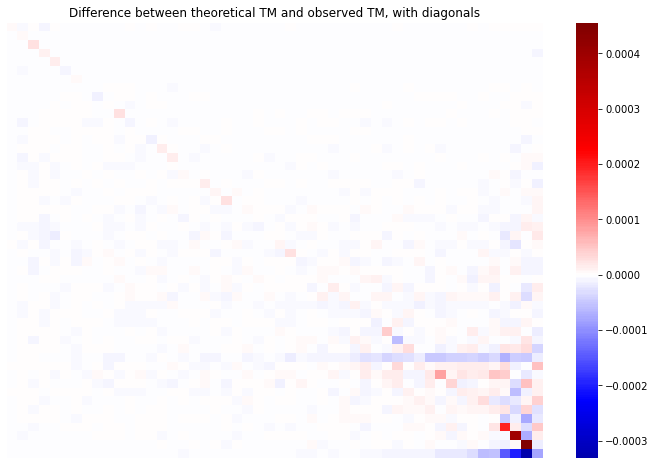

In [95]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


## TODO

Make a more effecient algorithm for getting this observed coalescent data

## Try out G function, as written in Distribution of coalesent times -Copy_210116


I will copy paste from the above notebook. I copy as of 2021/01/29 (ymd) - I hope that i don't change things in one script and not the other! 

In [11]:
def G(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

In [12]:
# this is cut and pasted from Distribution of coalesent times -Copy_210116.ipynb.
# As of 20210208, I am confident that my G_newnew function is correct

def psi_finder(ind,gamma_array):
    # find the last change in gamma: m is current location of iration
    i = 1
    psi = None
    while psi == None:
        if gamma_array[ind] == 1:
            psi = ind
        elif gamma_array[ind] == gamma_array[ind-i]:
            i += 1
        elif gamma_array[ind] != gamma_array[ind-i]:
            psi = ind-i+1
        else:
            print('There has been an error in psi finder!')
    return psi

def G_newnew(t1,t2,gamma_array,lambda_array,T):
    # assume t1 = 0 and work out G(t1,t2) by doing G(t1,t2)=G(0,t2)/G(0,t1)
    
    def lower_higher_intervals(t1,t2):
    # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
    #         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        elif ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
    #         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def G_upper(ind,t):
        sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
        psi = psi_finder(ind,gamma_array)
        numerator = 1 - sigma + sigma*np.exp(-(t-T[psi]))
        denominator = 1 - sigma + sigma*np.exp(-(T[ind]- T[psi]))
        G = numerator/denominator
        return G
    def G_main(ind1,ind2):
        recursion = 1
        G_set = np.array([])
        psi = psi_finder(ind1,gamma_array)
        sigma = (1-gamma_array[ind1])**2 + gamma_array[ind1]**2
        G_temp = (1 -sigma + sigma*np.exp(-(T[ind1+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[ind1]-T[psi])))
        recursion = recursion*G_temp
        G_set = np.append(G_set,G_temp)
        for i in range(ind1+1,ind2):
            psi = psi_finder(i,gamma_array)
            sigma = (1-gamma_array[i])**2 + gamma_array[i]**2
            G_temp = (1 -sigma + sigma*np.exp(-(T[i+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[i]-T[psi])))
            recursion = recursion*G_temp
            G_set = np.append(G_set,G_temp)
        G = np.prod(G_set)
        return G
    
    
    ind1, ind2 = lower_higher_intervals(t1,t2)
    
    G_upper_t2 = G_upper(ind2, t2)
    if ind2>0:
        G_main_t2 = G_main(0,ind2)
    elif ind2==0:
        G_main_t2=1
    G_t2 = G_main_t2*G_upper_t2
        
    if ind1==t1==0:
        G_t1 = 1
    else:
        G_upper_t1 = G_upper(ind1,t1)
        if ind1>0:
            G_main_t1 = G_main(0,ind1)
        elif ind1==0:
            G_main_t1 = 1
        G_t1 = G_main_t1*G_upper_t1
    
    G = G_t2/G_t1

    return G

        
    
    

I now need to rewrite my transition matrix theory with this function instead of L. In my notepad, page 15-17, I write what I expect the theoretical probabilities to be. They are cumbersome so I introduced new functions called H instead. I will also write that in the above block of code. 

Note that my G function is calibrated to run from t1=0 to t2 - i.e. it should be given G(0,t2)<br>.
Therefore, if you want a non t1!=0 start, you should do G(t1,t2)/G(0,t1) 

In [13]:
def structuredsplit_abinitio(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/lambda_)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H
        # TODO 210203 think we should have ((sigma)/lambda) above, not ((sigma)/gamma)

    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t < T[ind1]:
            print('There has been an error! T[ind] is bigger than t2, whereas t2 should be bigger than T[ind]')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/lambda_)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H
            # TODO 210203 think we should have ((sigma)/lambda) above, not ((sigma)/gamma)

#     def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
    def J(ind1): # this used to be called H_antidash
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        if sig==1:
            J = (1/(2*lambd))*(delt - (1/(2*lambd))*(1-np.exp(-2*delt*lambd)))
        else: 
            J = ((1-sig)**2)*( 0.5*(delt**2) ) + 2*(1-sig)*(sig/lambd)*(
                delt + (1/lambd)*(np.exp(-lambd*delt) - 1)
            ) + (((sig)**2)/(2*lambd))*(
            delt + (1/(2*lambd))*(np.exp(-2*lambd*delt) -1))
        return J
    
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2) * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*H_intervals(alpha) + J(alpha)               
                )
                pre = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha)
                A = upper_diag_sum(alpha)*H_intervals(alpha)
                B = J(alpha)
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    def lower_diag_sum(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G(T[j+1],expected_time(beta),gamma_array,lambda_array,T_np)**2)* H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
    def lower_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(0,alpha):

                # the integral of G over T[alpha] and T[alpha+1], see my notepad page 19
                G_integral_alpha = (1-sigma(alpha))*delta(alpha) + (sigma(alpha)/lambda_(alpha))*(1-np.exp(-delta(alpha)*lambda_(alpha)))
                
                
                q_2[alpha,beta] = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta))*(
                        lower_diag_sum(beta) + H_edge(beta,expected_time(beta))
                    ))

                pre = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta)))
                A = lower_diag_sum(beta) 
                B = H_edge(beta,expected_time(beta))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nB={}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    # flagstr
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2_lower is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    
    return q_2, q_2_upper, q_2_lower, q_1, q_

# flagqqj

def structuredsplit_abinitio_new(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def psi_finder(ind,gamma_array):
        # find the last change in gamma: m is current location of iration
        i = 1
        psi = None
        while psi == None:
            if gamma_array[ind] == 1:
                psi = ind
            elif gamma_array[ind] == gamma_array[ind-i]:
                i += 1
            elif gamma_array[ind] != gamma_array[ind-i]:
                psi = ind-i+1
            else:
                print('There has been an error in psi finder!')
        return psi

    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        psi = psi_finder(ind1,gamma_array)
        if gamma_array[psi]!=gamma_array[ind1]:
            print('problemo! gamma_psi != gamma_ind1')
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        H = ((1-sigma)**2)*(delta) + (
            2*(1-sigma)*((sigma)/lambda_)*np.exp(T[psi])*(np.exp(-T[ind1]) - np.exp(-T[ind1+1]))) + (
                    ((sigma**2)/(2*lambda_)) * (np.exp(-2*(T[ind1]-T[psi]))-np.exp(-2*(T[ind1+1] - T[psi]))))        
        return H*A
        
    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t < T[ind1]:
            print('there has been an error in H_edge! t < ind1')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        psi = psi_finder(ind1,gamma_array)
        if gamma_array[psi]!=gamma_array[ind1]:
            print('problemo! gamma_psi != gamma_ind1')
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        H = ((1-sigma)**2)*(delta) + (
            2*(1-sigma)*((sigma)/lambda_)*np.exp(T[psi])*(np.exp(-T[ind1]) - np.exp(-t))) + (
                    ((sigma**2)/(2*lambda_)) * (np.exp(-2*(T[ind1]-T[psi]))-np.exp(-2*(t - T[psi]))))        
        return H*A
            
#     def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
    def J(ind1): # this used to be called H_antidash
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        psi = psi_finder(ind1,gamma_array)
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        J = ((1-sig)**2)*( 0.5*(delt**2) ) + 2*(1-sig)*(sig/lambd)*(np.exp(T[psi]))*(
                np.exp(-T[ind1])*delt + np.exp(-T[ind1+1]) - np.exp(-T[ind1])) + (
                        ((sig**2)/(2*lambd))*( np.exp(-2*(T[ind1]-T[psi]))*delt + 0.5*np.exp(-2*(T[ind1+1]-T[psi])) - 0.5*np.exp(-2*(T[ind1]-T[psi])))
                                    )
        return J*A

    # flagqqw
        
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G_newnew(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2) * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha>=30:
#                     pdb.set_trace()
                
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*H_intervals(alpha) + J(alpha)               
                )
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    def lower_diag_sum(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G_newnew(T[j+1],expected_time(beta),gamma_array,lambda_array,T_np)**2)* H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
    def lower_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(0,alpha):

                # the integral of G over T[alpha] and T[alpha+1], see my notepad page 19
                psi = psi_finder(alpha,gamma_array)
                B = ( 1-sigma(alpha) + sigma(alpha)*np.exp(-(T[alpha] - T[psi])))**(-1)              
                G_integral_alpha = B*(
                (1-sigma(alpha))*delta(alpha) + (sigma(alpha)/lambda_(alpha))*(np.exp(-(T[alpha]-T[psi])) - np.exp(-(T[alpha+1]-T[psi]))))               
                
                q_2[alpha,beta] = G_newnew(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta))*(
                        lower_diag_sum(beta) + H_edge(beta,expected_time(beta))
                    ))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nB={}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    # flagstr
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2_lower is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    
    return q_2, q_2_upper, q_2_lower, q_1, q_

In [38]:
def structuredsplit_abinitio_newnew(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def psi_finder(ind,gamma_array):
        # find the last change in gamma: m is current location of iration
        i = 1
        psi = None
        while psi == None:
            if gamma_array[ind] == 1:
                psi = ind
            elif gamma_array[ind] == gamma_array[ind-i]:
                i += 1
            elif gamma_array[ind] != gamma_array[ind-i]:
                psi = ind-i+1
            else:
                print('There has been an error in psi finder!')
        return psi

    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        psi = psi_finder(ind1,gamma_array)
        if gamma_array[psi]!=gamma_array[ind1]:
            print('problemo! gamma_psi != gamma_ind1')
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        H = ((1-sigma)**2)*(delta) + (
            2*(1-sigma)*((sigma)/lambda_)*np.exp(T[psi])*(np.exp(-T[ind1]) - np.exp(-T[ind1+1]))) + (
                    ((sigma**2)/(2*lambda_)) * (np.exp(-2*(T[ind1]-T[psi]))-np.exp(-2*(T[ind1+1] - T[psi]))))        
        return H*A
        
    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t < T[ind1]:
            print('there has been an error in H_edge! t < ind1')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        psi = psi_finder(ind1,gamma_array)
        if gamma_array[psi]!=gamma_array[ind1]:
            print('problemo! gamma_psi != gamma_ind1')
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        H = ((1-sigma)**2)*(delta) + (
            2*(1-sigma)*((sigma)/lambda_)*np.exp(T[psi])*(np.exp(-T[ind1]) - np.exp(-t))) + (
                    ((sigma**2)/(2*lambda_)) * (np.exp(-2*(T[ind1]-T[psi]))-np.exp(-2*(t - T[psi]))))        
        return H*A
            
#     def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
    def J(ind1): # this used to be called H_antidash
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        psi = psi_finder(ind1,gamma_array)
#         A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        A = G_newnew(T[psi],T[ind1],gamma_array,lambda_array,T_np)**(-2)
        J = ((1-sig)**2)*( 0.5*(delt**2) ) + 2*(1-sig)*(sig/lambd)*(np.exp(T[psi]))*(
                np.exp(-T[ind1])*delt + np.exp(-T[ind1+1]) - np.exp(-T[ind1])) + (
                        ((sig**2)/(2*lambd))*( np.exp(-2*(T[ind1]-T[psi]))*delt + 0.5*np.exp(-2*(T[ind1+1]-T[psi])) - 0.5*np.exp(-2*(T[ind1]-T[psi])))
                                    )
        return J*A

    
    def P(ind1):
        psi = psi_finder(ind1,gamma_array)
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        if gamma_array[ind1] != gamma_array[psi]:
            print('problemo! In P(), gamma[ind1] != gamma[psi]!')
        B = (1 - sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-1)
        P = (1-sigma)*(1-np.exp(-(delta))) + (sigma/2)*(np.exp(-(T[ind1]-T[psi]))-np.exp(-(2*T[ind1+1] - T[ind1] - T[psi])))
        P = P*B
        return P
    
    def R(ind1):
        psi = psi_finder(ind1,gamma_array)
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        if gamma_array[ind1] != gamma_array[psi]:
            print('problemo! In R(), gamma[ind1] != gamma[psi]!')
        A = (1-sigma + sigma*np.exp(-(T[ind1]-T[psi])))**(-2)
        R = ((1-sigma)**2)*( (T[ind1+1]+1)*(-np.exp(-delta)) + T[ind1]*np.exp(-delta)+1 ) + 2*(1-sigma)*sigma*(                
                    -np.exp(-(T[ind1+1]-T[psi])) + 0.5*np.exp(-(2*T[ind1+1] -T[ind1]-T[psi])) + np.exp(-(T[ind1]-T[psi])) - 0.5*np.exp(-(T[ind1]-T[psi]))) + (
                        (sigma**2)/2)*(-np.exp(-(T[ind1+1]+T[ind1]-2*T[psi])) + (1/3)*np.exp(-(3*T[ind1+1] -T[ind1] - 2*T[ind1])) + 
                                        np.exp(-(2*T[ind1]-2*T[psi])) -(1/3)*np.exp(-(2*T[ind1]-2*T[psi])))
        return R*A
        
    # flagqqq
        
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G_newnew(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2) * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha>=30:
#                     pdb.set_trace()
                
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*P(alpha) + R(alpha)               
                )
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    def lower_diag_sum(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (G_newnew(T[j+1],expected_time(beta),gamma_array,lambda_array,T_np)**2)* H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
    def lower_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(0,alpha):

                # the integral of G over T[alpha] and T[alpha+1], see my notepad page 19
                psi = psi_finder(alpha,gamma_array)
                B = ( 1-sigma(alpha) + sigma(alpha)*np.exp(-(T[alpha] - T[psi])))**(-1)              
                G_integral_alpha = B*(
                (1-sigma(alpha))*delta(alpha) + (sigma(alpha)/lambda_(alpha))*(np.exp(-(T[alpha]-T[psi])) - np.exp(-(T[alpha+1]-T[psi]))))               
                
                q_2[alpha,beta] = G_newnew(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta))*(
                        lower_diag_sum(beta) + H_edge(beta,expected_time(beta))
                    ))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nB={}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    # flagstr
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2_lower is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    
    return q_2, q_2_upper, q_2_lower, q_1, q_

In [14]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_np is {T_np}\n\n')
# print(f'T_scaled_np is {T_scaled_np}')

In [15]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

# gamma_array[30:40] = 0.2

In [16]:
q_2s, q_2_uppers, q_2_lowers,q_1s, q_s = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

expected_times conforms with T.
Finished


In [17]:
q_2ss, q_2_upperss, q_2_lowerss,q_1ss, q_ss = structuredsplit_abinitio_new(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

expected_times conforms with T.
Finished


In [18]:
gamma_array

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
# should be 
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


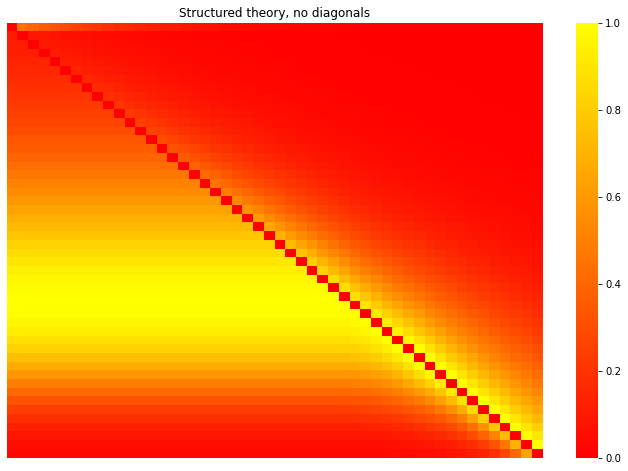

In [41]:
# heatmaps_seq(normalise(q_2_uppers,'colmax'),title="upper from structured theory!")
# heatmaps_seq(normalise(q_2_lowers,'colmax'),title="lower from structured theory!")
heatmaps_seq(normalise(q_2s,'colmax'),title="Structured theory, no diagonals")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


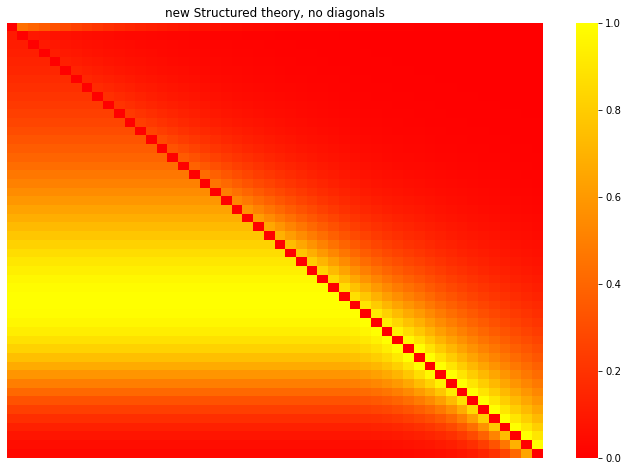

In [22]:
heatmaps_seq(normalise(q_2ss,'colmax'),title="new Structured theory, no diagonals")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


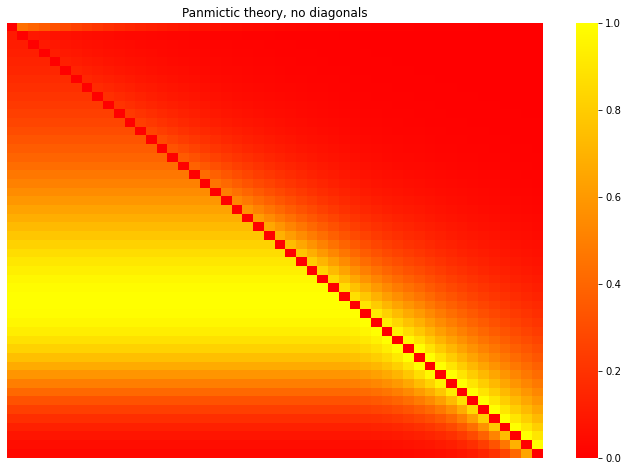

In [42]:
heatmaps_seq(normalise(q_2Ac,'colmax'),title="Panmictic theory, no diagonals")

Looks to me, just by eyeballing, that panmictic theory matches structed theory

In [23]:
checking_q_upper = q_2_upperAc - q_2_uppers
checking_q_lower = q_2_lowerAc - q_2_lowers
checking_q_all = q_Ac - q_s
checking_q_struct_all = q_s - q_ss


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


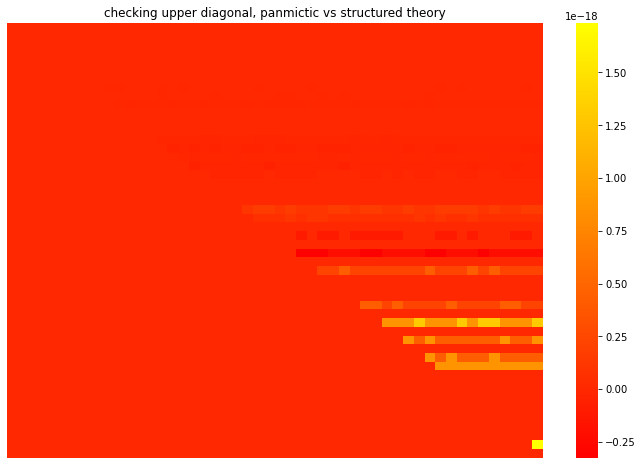

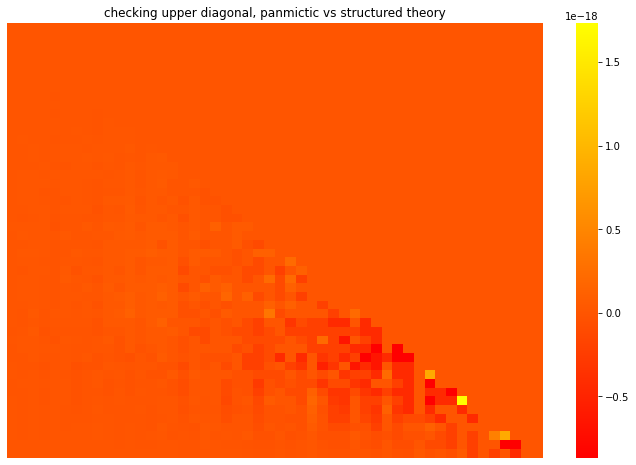

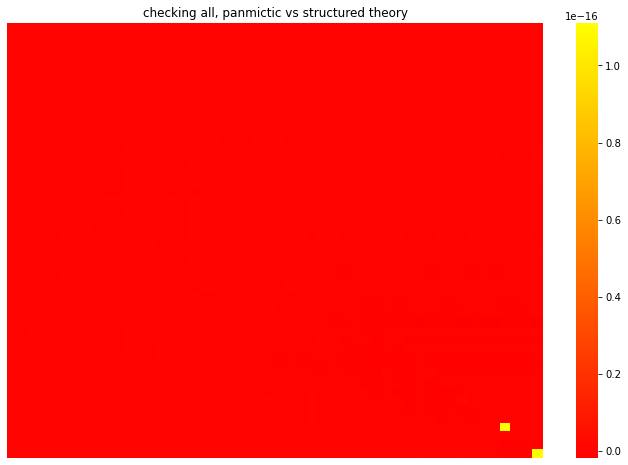

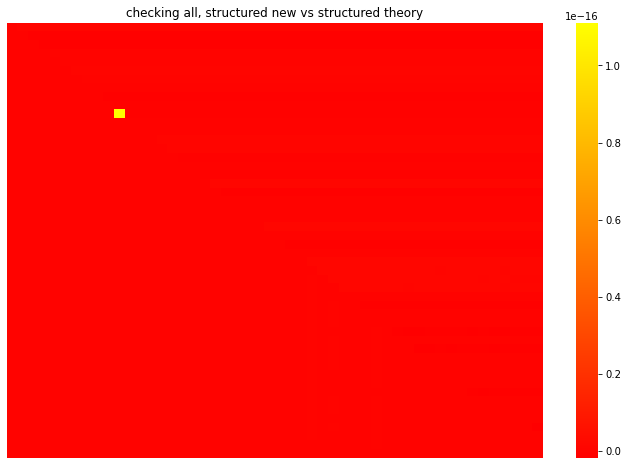

In [24]:
heatmaps_seq(-checking_q_upper,title="checking upper diagonal, panmictic vs structured theory") # minus to flip colours, looks weird otherwise
heatmaps_seq(checking_q_lower,title="checking upper diagonal, panmictic vs structured theory")
heatmaps_seq(checking_q_all,title="checking all, panmictic vs structured theory")
heatmaps_seq(checking_q_struct_all,title="checking all, structured new vs structured theory")

Very small differences in TM. Not sure if that is ok?. I think it is. This plot is a difference between corrected_abinitio and structuredsplit_abinitio

## Now try my theory for structured transition matrix and see if it fits observations

In [8]:
T_1 = T_np[30]*2*N_0
T_2 = T_np[40]*2*N_0
print('T_1 is {} and T_2 is {}'.format(T_1,T_2))
mig_prop = 0.2
seq_length=150e+06
N_0 = 10000

sim3 = split(N_0,mig_prop,T_1,T_2,seq_length)
print('finished!')

T_1 is 15943.704151042171 and T_2 is 46049.87318513843
N is 10000
mig_prop is 0.2
t_1 is 15943.704151042171 and t_2 is 46049.87318513843
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 15943.704151042171 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 15943.704151042171
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 15943.704151042171 -- 46049.87318513843 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @

In [9]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

Record observed transitions

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


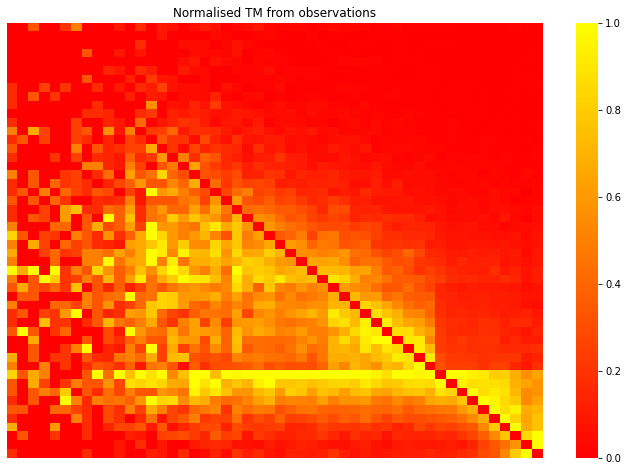

In [12]:
tmrca_data3 = get_coal_data(sim3, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim3.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised TM from observations') # show heatmap


Now test with my (old) theory

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


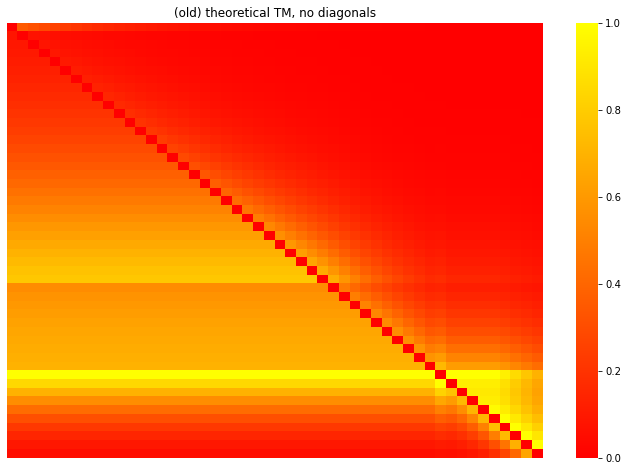

In [29]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[30:40] = 0.2
print(gamma_array)
q_2D, q_2_upperD, q_2_lowerD, q_1D, q_D = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2D,'colmax'),title='(old) theoretical TM, no diagonals') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperD,'colmax'),title='(old) theoretical TM, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerD,'colmax'),title='(old)  theoretical TM, lower ') # normalise this matrix and then plot heatmap


Now try and look at the actual differences.

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


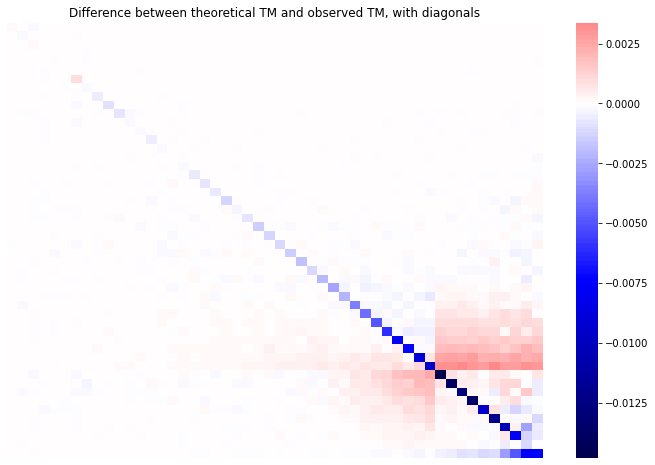

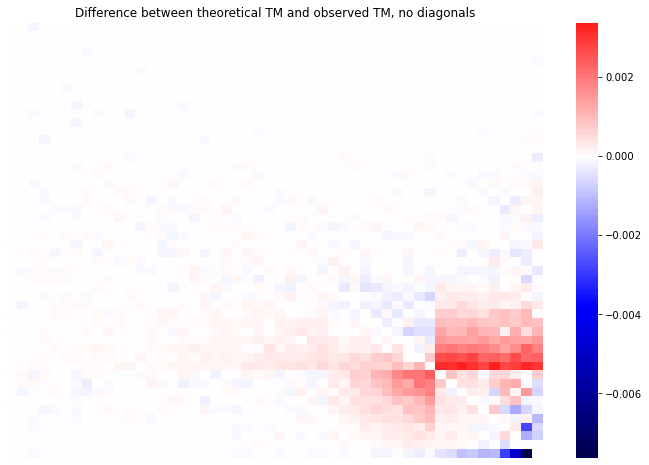

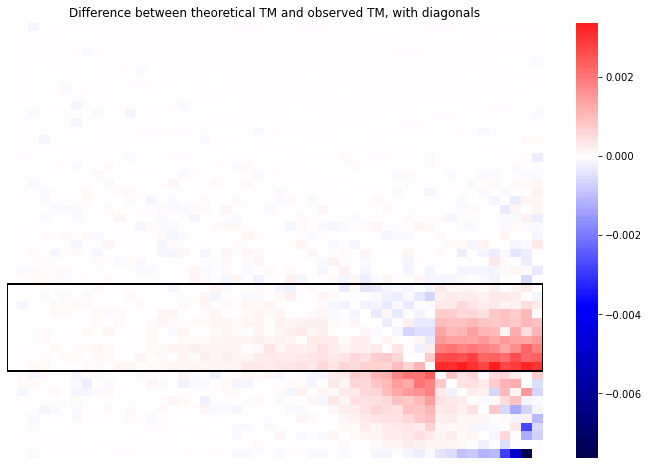

In [32]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_D_3 = q_D - tm_3 # difference between simulation 3's TM and theoretical TM for that history
diff_q_D_3_nd = np.copy(diff_q_D_3)
diff_q_D_3_nd = remove_diagonals(diff_q_D_3_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_D_3,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_D_3_nd,title="Difference between theoretical TM and observed TM, no diagonals")


heatmaps_div_patch(diff_q_D_3_nd,title="Difference between theoretical TM and observed TM, with diagonals",patch=[30,10])


Some bias. Not good enough!

#### Test with my new theory

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


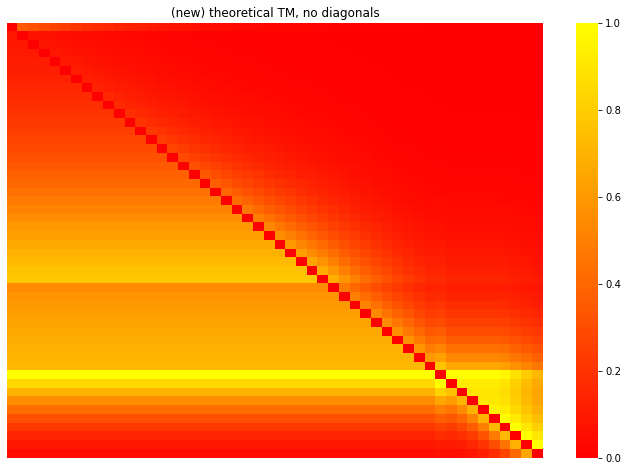

In [35]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[30:40] = 0.2
print(gamma_array)
q_2Dn, q_2_upperDn, q_2_lowerDn, q_1Dn, q_Dn = structuredsplit_abinitio_new(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2Dn,'colmax'),title='(new) theoretical TM, no diagonals') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperD,'colmax'),title='theoretical TM, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerD,'colmax'),title='theoretical TM, lower ') # normalise this matrix and then plot heatmap
# flagtest

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


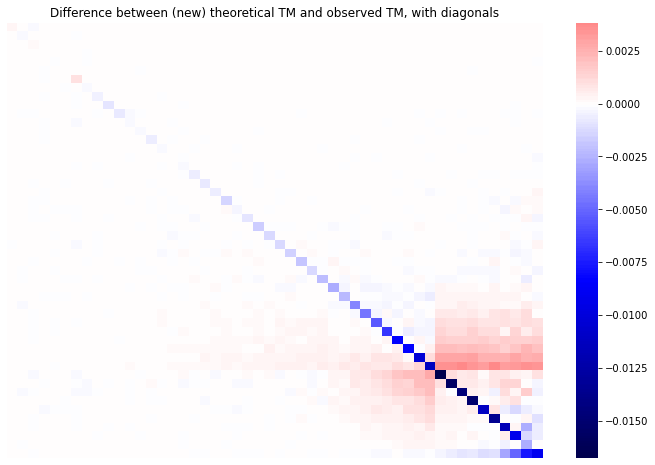

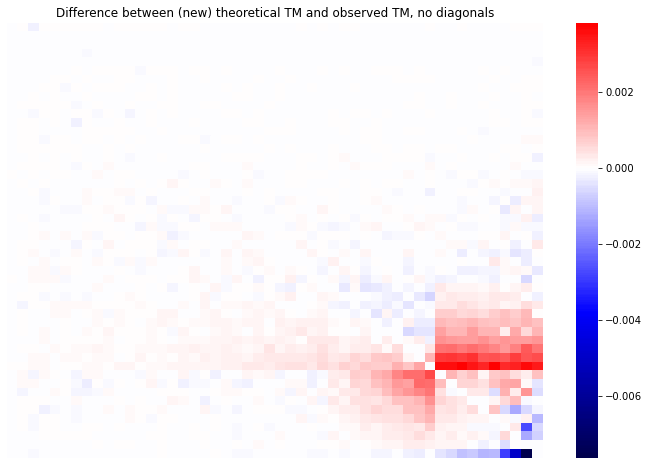

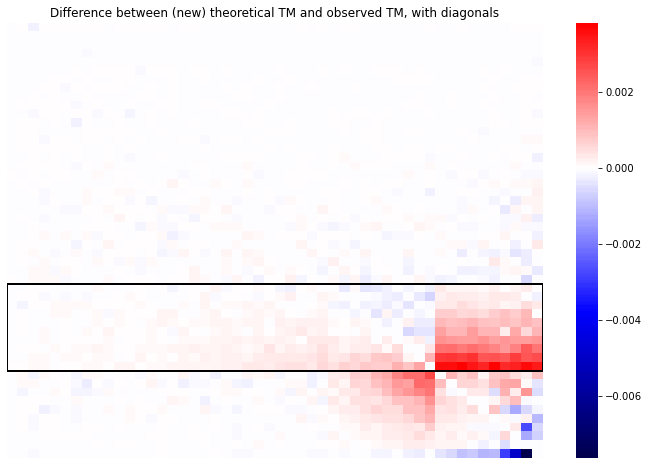

In [36]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_D_3 = q_Dn - tm_3 # difference between simulation 3's TM and theoretical TM for that history
diff_q_D_3_nd = np.copy(diff_q_D_3)
diff_q_D_3_nd = remove_diagonals(diff_q_D_3_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_D_3,title="Difference between (new) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_D_3_nd,title="Difference between (new) theoretical TM and observed TM, no diagonals")


heatmaps_div_patch(diff_q_D_3_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[30,10])


Still not good enough! Bias

Test with my new new theory

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


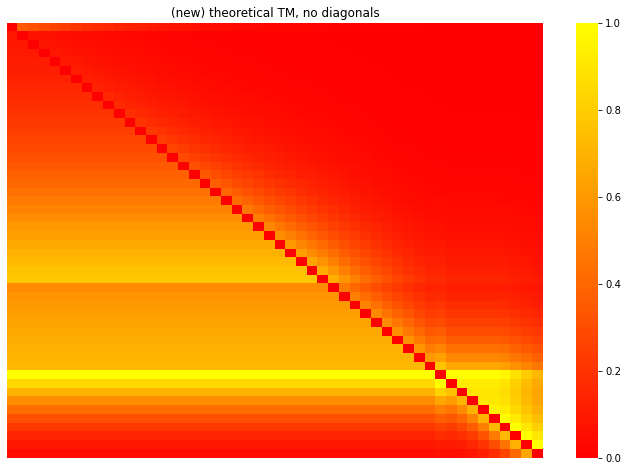

In [39]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[30:40] = 0.2
print(gamma_array)
q_2Dnn, q_2_upperDnn, q_2_lowerDnn, q_1Dnn, q_Dnn = structuredsplit_abinitio_newnew(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2Dn,'colmax'),title='(new) theoretical TM, no diagonals') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperD,'colmax'),title='theoretical TM, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerD,'colmax'),title='theoretical TM, lower ') # normalise this matrix and then plot heatmap
# flagtest

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


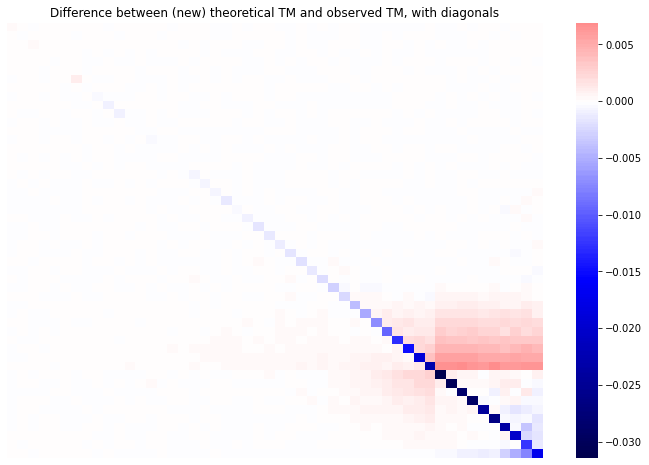

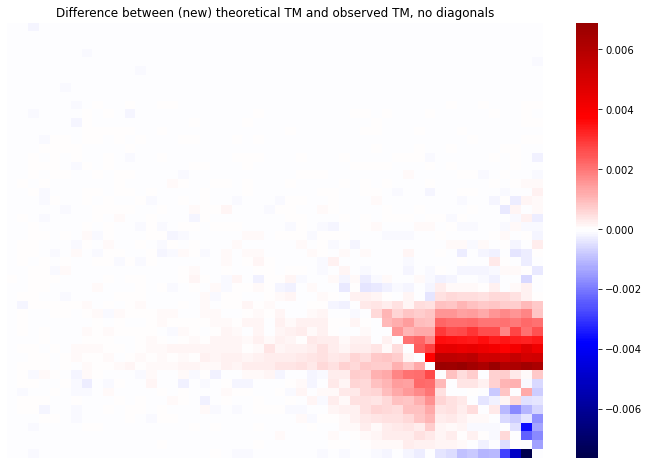

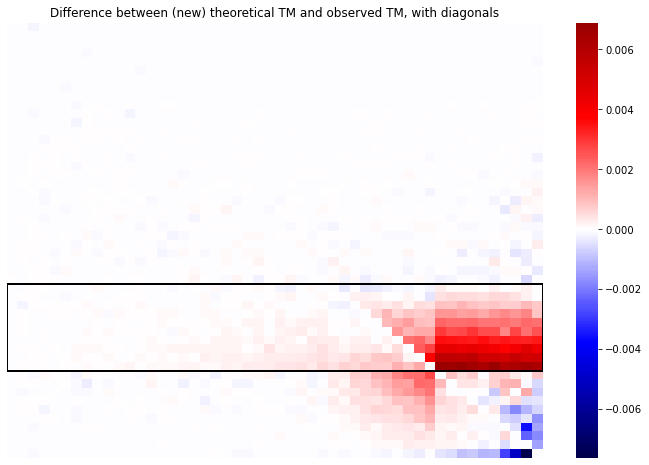

In [40]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_D_3n = q_Dnn - tm_3 # difference between simulation 3's TM and theoretical TM for that history
diff_q_D_3n_nd = np.copy(diff_q_D_3n)
diff_q_D_3n_nd = remove_diagonals(diff_q_D_3n_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_D_3n,title="Difference between (new) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_D_3n_nd,title="Difference between (new) theoretical TM and observed TM, no diagonals")


heatmaps_div_patch(diff_q_D_3n_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[30,10])


Even worse! Need to re think things. 

In [70]:
def lower_higher_intervals(t1,t2,T):
    # get the index of the next lower or equal time intervals for t1 and t2
    ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
    if T[ind1] > t1:
        ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
    ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
    if T[ind2] > t2:
        ind2 = ind2 - 1
    if ind2 == N_T:
        # if ind2 is the last time interval, remove 1 otherwise will crash
        ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
    return ind1, ind2

def delta(int,T):
    # difference in each time interval
    delta_ = T[int+1] - T[int]
    return delta_

def psis_finder(gamma_array):
    # find the first change in gamma (psi_s) and last change in gamma (psi_e)
    # for now, assume there is only one period of structure

    try:
        psi_s = np.where(gamma_array!=1)[0][0]
        psi_e = np.where(gamma_array!=1)[0][-1]
    except:
        psi_e = None
        psi_s = None
        print('Psi is None')
    return psi_s, psi_e


def new_structuredsplit_abinitio(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    def sigma(i):
        # return sigma
        sig = gamma_array[i]**2 + (1-gamma_array[i])**2
        return sig

    def L(time1,time2):
        # go from 0 to time2, then 0 to time1, and divide
        # TODO write the below double paragraph of code into one loop

        ind1, ind2 = lower_higher_intervals(time1,time2,T) # get index of intervals

        ind = ind1
        time = time1
        if ind == 0:
            L_lower = np.exp(-time/lambda_array[ind])
        else:
            sum = 0
            for i in range(0,ind):
                sum = sum + delta(i,T_np)/lambda_array[i]
            L_lower = np.exp(-sum - (time - T[ind])/lambda_array[ind])

        ind = ind2
        time = time2
        if ind == 0:
            L_upper = np.exp(-time/lambda_array[ind])
        else:
            sum = 0
            for i in range(0,ind):
                sum = sum + delta(i,T_np)/lambda_array[i]
            L_upper = np.exp(-sum - (time - T[ind])/lambda_array[ind])

        L = L_upper/L_lower
        return L
    
    def G(time1,time2,psi_s,psi_e):
        # wrap this around L
        time = time1
        if (psi_s is not None)and time >= T[psi_e+1]:
            sig = sigma(psi_e)
            G_lower = L(0,T_np[psi_s])*(1-sig + sig*L(T_np[psi_s],T_np[psi_e+1]))*L(T_np[psi_e+1],time)
        else:
            G_lower = L(0,time)

        time = time2
        if (psi_s is not None)and time >= T[psi_e+1]:
            sig = sigma(psi_e)
            G_upper = L(0,T_np[psi_s],)*(1-sig + sig*L(T_np[psi_s],T_np[psi_e+1]))*L(T_np[psi_e+1],time)
        else:
            G_upper = L(0,time)

        G = G_upper/G_lower
        return G
            

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_

    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_array[i] * delta(i,T)
        numerator =  np.exp(-sum)* (
            (T[int]*lambda_array[int] + 1) -  np.exp(-delta(int,T)*lambda_array[int])*(T[int+1]*lambda_array[int] + 1)
        )
        denominator = L(0,T[int]) * (1-np.exp(-delta(int,T)*lambda_array[int])) * lambda_array[int]
        # TODO replace this L in denominator with G?
        
        expec_time = numerator / denominator
        return expec_time


    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        elif good is False:
            print('expected_times does not conform with T')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    # it is used in expected_time calculation, though is calculated explicitly. 
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - np.exp(-delta(int,T) * lambda_array[int]))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_array[j]))*(1 - np.exp(-2*lambda_array[j]*delta(j,T)))*(G(T[j+1],T[alpha],psi_s,psi_e)**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - np.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_array[alpha] * sigma(alpha)* (
                        (1/(2*lambda_array[alpha]))*(1 - np.exp(-2 * delta(alpha,T) * lambda_array[alpha])) * q_2_sum1(alpha) + (1 / (2 * lambda_array[alpha])) * (delta(alpha,T) - (1 / (2 * lambda_array[alpha])) * (1 - np.exp(-2 * delta(alpha,T) * lambda_array[alpha])))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T),psi_s,psi_e)**2)*(1/(2*lambda_array[j]))*(1 - np.exp(-2*lambda_array[j]*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = G(expected_time(beta,T), T[alpha],psi_s,psi_e) * (1 / lambda_array[alpha]) * (1 - np.exp(-delta(alpha,T) * lambda_array[alpha])) * (1 - np.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_array[alpha] * sigma(alpha) *(
                                        q_2_sum2(beta) + (1 / (2 * lambda_array[beta])) * (1 - np.exp(-2 * lambda_array[beta] * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    psi_s, psi_e = psis_finder(gamma_array)
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    

    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

In [66]:
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)
# gamma_array[15:18] = 0.4
print(gamma_array)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [40]:
def psis_finder(gamma_array):
    # find the first change in gamma (psi_s) and last change in gamma (psi_e)
    # for now, assume there is only one period of structure
    psi_s = np.where(gamma_array!=1)[0][0]
    psi_e = np.where(gamma_array!=1)[0][-1]
    return psi_s, psi_e

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


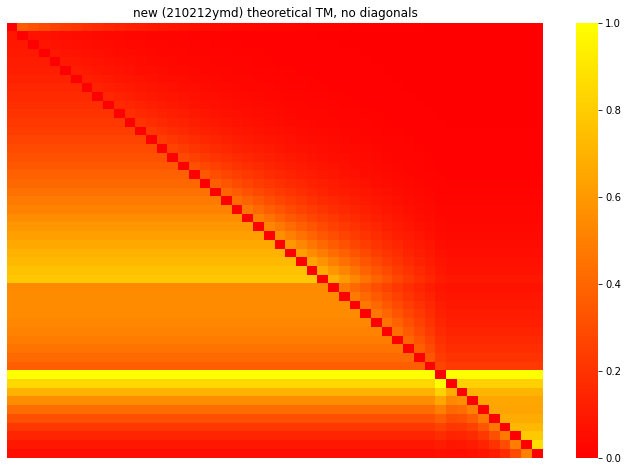

In [43]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[30:40] = 0.2
print(gamma_array)

q_2E, q_2_upperE, q_2_lowerE, q_1E, q_E = new_structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08)
heatmaps_seq(normalise(q_2E,'colmax'),title='new (210212ymd) theoretical TM, no diagonals') # normalise this matrix and then plot heatmap


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


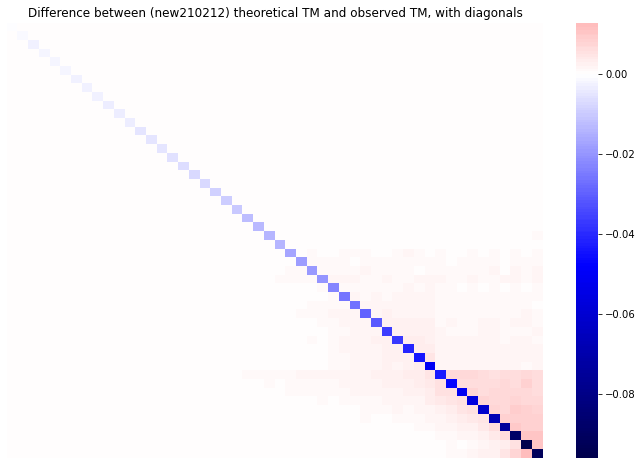

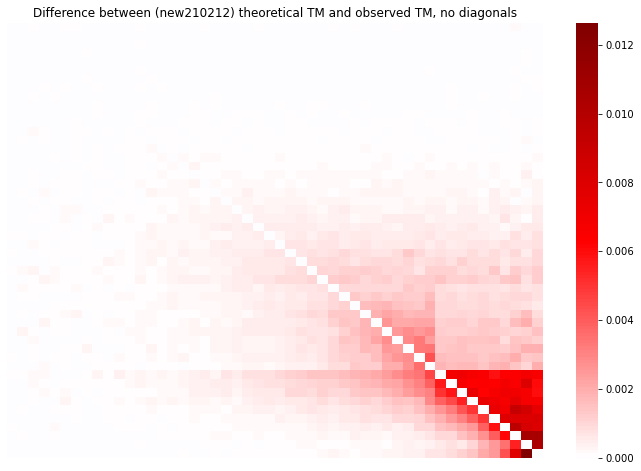

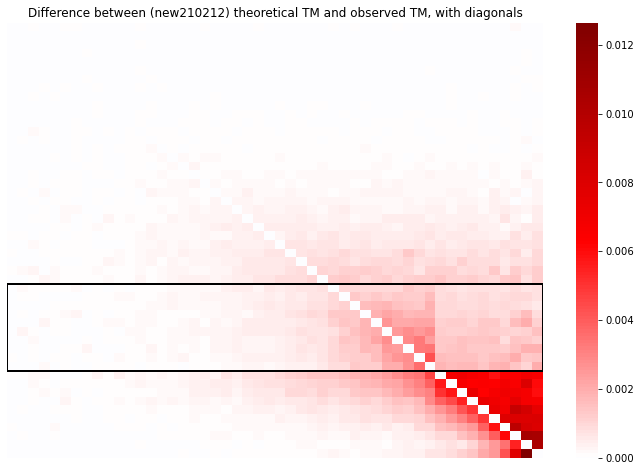

In [32]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_E_3 = tm_3 - q_E  # difference between simulation 3's TM and theoretical TM for that history
diff_q_E_3_nd = np.copy(diff_q_E_3)
diff_q_E_3_nd = remove_diagonals(diff_q_E_3_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_E_3,title="Difference between (new210212) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_E_3_nd,title="Difference between (new210212) theoretical TM and observed TM, no diagonals")


heatmaps_div_patch(diff_q_E_3_nd,title="Difference between (new210212) theoretical TM and observed TM, with diagonals",patch=[30,10])


Compare corrected_abinitio and my new_structured_split

In [48]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)

pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


In [72]:
q_2E, q_2_upperE, q_2_lowerE, q_1E, q_E = new_structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08)


Psi is None
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


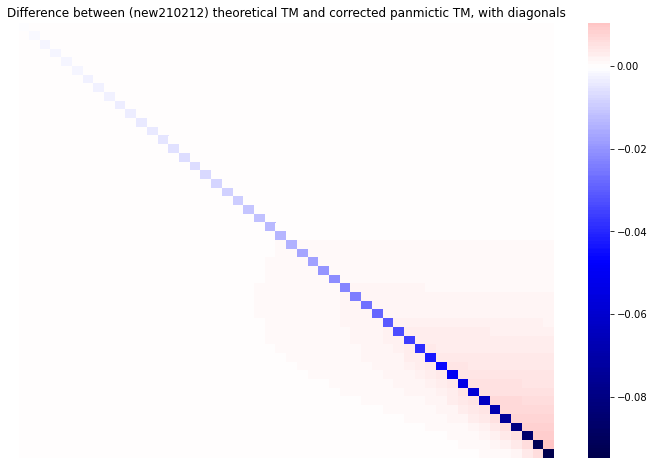

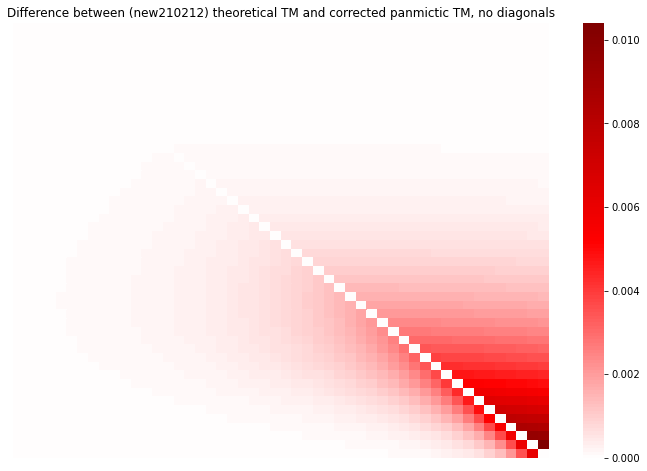

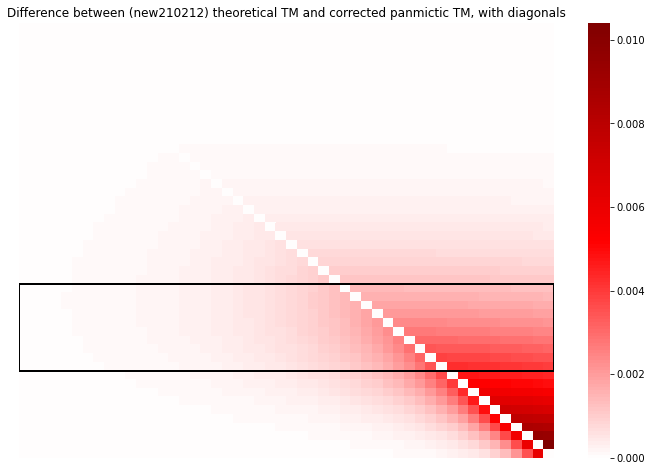

In [74]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_E_A = q_Ac - q_E  # difference between simulation 3's TM and theoretical TM for that history
diff_E_A_nd = np.copy(diff_E_A)
diff_E_A_nd  = remove_diagonals(diff_E_A_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_E_A,title="Difference between (new210212) theoretical TM and corrected panmictic TM, with diagonals")
heatmaps_div(diff_E_A_nd,title="Difference between (new210212) theoretical TM and corrected panmictic TM, no diagonals")


heatmaps_div_patch(diff_E_A_nd,title="Difference between (new210212) theoretical TM and corrected panmictic TM, with diagonals",patch=[30,10])


In [54]:
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)
print(gamma_array)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [31]:
# this heatmap works well for values between -1 and 1
def heatmaps_div_patch(matrix,title='',patch=[1,1]):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax.add_patch(Rectangle((0, patch[0]), len(matrix), patch[1], fill=False, edgecolor='black', lw=2))
#     ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

from matplotlib.patches import Rectangle

In [104]:
def psi_finder(ind,gamma_array):
    # find the last change in gamma: m is current location of iration
    i = 1
    psi = None
    while psi == None:
        if gamma_array[ind] == 1:
            psi = ind
        elif gamma_array[ind] == gamma_array[ind-i]:
            i += 1
        elif gamma_array[ind] != gamma_array[ind-i]:
            psi = ind-i+1
        else:
            print('There has been an error in psi finder!')
    return psi

In [105]:
psi_finder(49,gamma_array)

49

In [71]:
# G(0.03,1.9,gamma_array,lambda_array,T_np)**2 - (G(0.03,T_np[36],gamma_array,lambda_array,T_np)**2)*(G(T_np[36],1.9,gamma_array,lambda_array,T_np))**2

# psi = psi_finder(gamma_array,36)
t = T[36]+0.15
actual = G_newnew(T[36],t,gamma_array,lambda_array,T_np)
actual2 = G_newnew(T[30],T[31],gamma_array,lambda_array,T_np)
actual3 = G_newnew(T[30],T[32],gamma_array,lambda_array,T_np)

sigma = (1-0.2)**2 + 0.2**2

test = (1-sigma+sigma*np.exp(-(t-T[30])))/(1-sigma+sigma*np.exp(-(T[36]-T[30])))
test2 = (1-sigma+sigma*np.exp(-(T[31]-T[30])))
test3 = (1-sigma+sigma*np.exp(-(T[32]-T[30])))/(1-sigma+sigma*np.exp(-(T[31]-T[30])))

print('test is {} and actual is {}'.format(test,actual))
print('test2 is {} and actual2 is {}'.format(test2,actual2))
print('test3 is {} and actual is {}'.format(test3,actual3))

test is 0.9288029317849339 and actual is 0.928802931784934
test2 is 0.9419697547507744 and actual2 is 0.9419697547507744
test3 is 0.9376540353658998 and actual is 0.8832417417346906


In [73]:
ind = 25
t = T[ind] + 0.04
print('T[ind] is {} and t is {}'.format(T[ind],t))
g = G_newnew(T[25],t,gamma_array,lambda_array,T_np)
sigma = 1
print('sigma is {}'.format(sigma))
g_theory = 1-sigma + sigma*np.exp(-(t-T[25]))
print('g is {} and g_theory is {}'.format(g,g_theory))

T[ind] is 0.46907212527470155 and t is 0.5090721252747016
sigma is 1
g is 0.9607894391523232 and g_theory is 0.9607894391523232


In [74]:
ind = 30
t = T[ind] + 0.08
print('T[ind] is {} and t is {}'.format(T[ind],t))
g = G_newnew(T[ind],t,gamma_array,lambda_array,T_np)
sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
print('sigma is {}'.format(sigma))
g_theory = 1-sigma + sigma*np.exp(-(t-T[ind]))
print('g is {} and g_theory is {}'.format(g,g_theory))

T[ind] is 0.7971852075521085 and t is 0.8771852075521085
sigma is 0.6800000000000002
g is 0.9477191155429123 and g_theory is 0.9477191155429123


In [75]:
ind = 31
t = T[ind] + 0.08
print('T[ind] is {} and t is {}'.format(T[ind],t))
g = G_newnew(T[ind],t,gamma_array,lambda_array,T_np)
sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
print('sigma is {}'.format(sigma))
g_theory = 1-sigma + sigma*np.exp(-(t-T[ind]))
print('g is {} and g_theory is {}'.format(g,g_theory))

T[ind] is 0.8863865399679676 and t is 0.9663865399679675
sigma is 0.6800000000000002
g is 0.9492347743214966 and g_theory is 0.9477191155429123


In [139]:
ind = 39
t = T[ind] + 0.2
if t > T[ind+1]:
    print('*****************Error! t should not be bigger than T[ind+1]*****************')
print('T[ind] is {} and t is {} and T[ind+1] is {}'.format(T[ind],t,T[ind+1]))
g = G(T[ind],t,gamma_array,lambda_array,T_np)
sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
print('sigma is {}'.format(sigma))
g_theory = 1-sigma + sigma*np.exp(-(t-T[ind]))
print('g is {} and g_theory is {}'.format(g,g_theory))

T[ind] is 2.0707826697238376 and t is 2.270782669723838 and T[ind+1] is 2.3024936592569216
sigma is 0.6800000000000002
g is 0.8767369120930275 and g_theory is 0.8767369120930275


In [162]:
ind = 33
t = (T[ind+1]) *(1) 
if t > T[ind+1]:
    print('*****************Error! t should not be bigger than T[ind+1]*****************')
print('T[ind] is {} and t is {} and T[ind+1] is {}'.format(T[ind],t,T[ind+1]))
g = G(T[ind],t,gamma_array,lambda_array,T_np)
sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
print('sigma is {}'.format(sigma))
g_theory = (1-sigma + sigma*np.exp(-(t-T[ind])))
print('g is {} and g_theory is {}'.format(g,g_theory))

T[ind] is 1.0958497044692084 and t is 1.2184702107707996 and T[ind+1] is 1.2184702107707996
sigma is 0.6800000000000002
g is 0.9293917516706728 and g_theory is 0.921527523136653


### TODO

Need to find a closed form equation of G(T[i],t) where T[i] is the next closest time interval to t. Then I think I could properly solve the integral of G over u, and then of G over alpha and alpha+1. 